In [200]:
import os
import pickle
import cv2
import numpy as np
import math
import time
import sys 
import heapq

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

import shapely.geometry
import shapely.ops

### Dijkstra code - for computing shortest path

https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/

In [210]:
from collections import defaultdict

class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

In [212]:
graph = Graph()

edges = [
    ('X', 'A', 7),
    ('X', 'B', 2),
    ('X', 'C', 3),
    ('X', 'E', 4),
    ('A', 'B', 3),
    ('A', 'D', 4),
    ('B', 'D', 4),
    ('B', 'H', 5),
    ('C', 'L', 2),
    ('D', 'F', 1),
    ('F', 'H', 3),
    ('G', 'H', 2),
    ('G', 'Y', 2),
    ('I', 'J', 6),
    ('I', 'K', 4),
    ('I', 'L', 4),
    ('J', 'L', 1),
    ('K', 'Y', 5),
]

for edge in edges:
    graph.add_edge(*edge)
    
dijsktra(graph, 'X', 'Y')

['X', 'B', 'H', 'G', 'Y']

In [347]:
def normalize_angle(angle):
    """ Normalize angle to between +pi and -pi """
    """ Important for EKF Correction Step !!!  """
    return (angle+math.pi)%(2*math.pi)-math.pi

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def robot_pose_delta(v,w,theta,dt):
    """ Calculate change in robot pose in world frame """
    
    """ An alternate way - can avoid divide by zero error if w is zero
    x_delta = v*dt*math.cos(theta)
    y_delta = v*dt*math.sin(theta)
    """
    arc_radius = v/w   # arc radius
    
    x_delta = arc_radius*(math.sin(theta+w*dt)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*dt))
    theta_delta = w*dt
    
    return x_delta, y_delta, theta_delta

## Landmarks and Central Barrier

In [248]:
# Landmarks
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[0.7,1.55],[0.8,1.45]],    
    "barrier": np.array([[0.8,1.55],
                    [0.8,1.45],
                    [0.7,1.45],
                    [0.7,1.55]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.50,
    "actual_y": 1.21,
    "Mu": [],
    "blocked": [[-1.45,2.18],[-0.25,0.5]],    
    "barrier": np.array([[-1.45,2.18],
                    [-0.25,2.18],
                    [-0.25,1.8],                         
                    [-0.25,1.4], 
                    [-0.25,1.0],
                    [-0.25,0.5],
                    [-1.45,0.5],
                    [-1.45,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 64,
    "obj_name": 'potted plant',
    "width": 0.55,
    "observed": False,
    "actual_x": 0.5,
    "actual_y": -0.10,
    "Mu": [],
    "blocked": [[0.2,0.1],[0.8,-0.3]],    
    "barrier": np.array([[0.2,0.1],
                    [0.8,0.1],
                    [0.8,-0.3],
                    [0.2,-0.3]
                   ])
    }
]

# Central barrier - 0.5m x 0.5m
barrier = np.array([[0.5,0.5],
                    [0.5,0.75],
                    [0.5,1.0],
                    [0.75,1.0],
                    [1.0,1.0],
                    [1.0,0.75],
                    [1.0,0.5],
                    [0.75,0.5]
                   ])

blocked = [[0.5,1.0],[1.0,0.5]]

### Plot Map

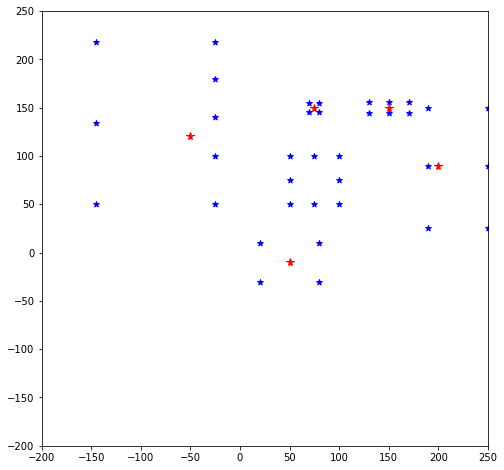

In [314]:
""" Update robot position on map """
plt.figure(figsize=(8,8))
plt.xlim([-200,250])
plt.ylim([-200,250])

    
""" Display landmark as green cross, uncorrected landmark as lime cross """
for i, landmark in enumerate(landmarks):
    # Mark landmark's actual locations
    landmark_x_actual = landmark["actual_x"]*100
    landmark_y_actual = landmark["actual_y"]*100
    plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red')
    
    if landmark["blocked"] is not None:
        plt.scatter(landmark["barrier"][:,0]*100, landmark["barrier"][:,1]*100, marker='*', color='blue') 
    
""" Display central barrier """
plt.scatter(barrier[:,0]*100, barrier[:,1]*100, marker='*', color='blue')     

plt.show()
plt.close()

## Voronoi Diagram --> Legal Paths

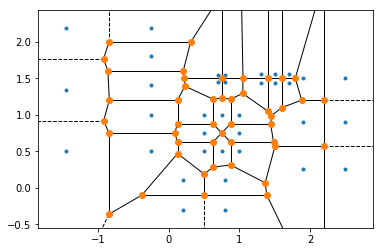

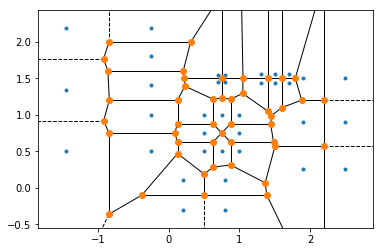

In [315]:
from scipy.spatial import Voronoi, voronoi_plot_2d

num_pt = 0
for landmark in landmarks:
        landmark_barrier = landmark["barrier"]
        num, _ = landmark_barrier.shape
        num_pt += num
        
num, _ = barrier.shape
num_pt += num
points = np.zeros((num_pt,2))

# create landmark points
j = 0
for landmark in landmarks:
        landmark_barrier = landmark["barrier"]
        num, _ = landmark_barrier.shape
        for i in range(num):
            points[j,0] = landmark_barrier[i,0]
            points[j,1] = landmark_barrier[i,1]
            j += 1
    
# create barrier points
num, _ = barrier.shape
for i in range(num):
    points[j,0] = barrier[i,0]
    points[j,1] = barrier[i,1]    
    j += 1
    
vor = Voronoi(points)
voronoi_plot_2d(vor)

3 4 [0.30789474 1.99      ] [0.20526316 1.6       ] 0.4032781186690274
7 16 [0.22105263 1.5       ] [0.22679641 1.39086826] 0.10928278398543254
16 17 [0.22679641 1.39086826] [0.625      1.21388889] 0.4357611735325622
17 18 [0.625      1.21388889] [0.75       1.22777778] 0.12576923802968634
3 8 [0.30789474 1.99      ] [0.75       2.65666667] 0.7999384402292186
4 7 [0.20526316 1.6       ] [0.22105263 1.5       ] 0.10123886348248064
20 23 [0.875  0.3125] [0.625   0.28125] 0.25194555463432966
20 22 [0.875  0.3125] [1.36463415 0.06768293] 0.547427617662296
21 22 [ 1.3875 -0.1   ] [1.36463415 0.06768293] 0.16923478133517178
23 24 [0.625   0.28125] [0.5    0.1875] 0.15625
10 11 [1.48333333 0.625     ] [1.50555556 0.575     ] 0.054715876676645035
11 22 [1.50555556 0.575     ] [1.36463415 0.06768293] 0.5265258363132839
1 21 [ 2.2   -1.725] [ 1.3875 -0.1   ] 1.816805231718579
13 14 [-0.38055556 -0.1       ] [0.125   0.46875] 0.7609618796320131
14 24 [0.125   0.46875] [0.5    0.1875] 0.46875
0 13

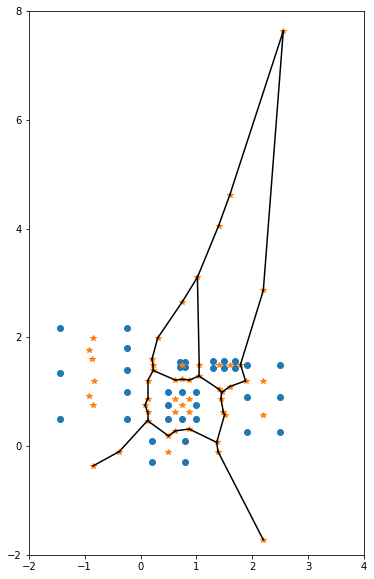

In [316]:
def in_blocked_area(blocked, point):
    """ Check if a point falls within a blocked region """
    x,y = point
    ULeft_x, ULeft_y = blocked[0]
    LRight_x, LRight_y = blocked[1]
    
    if (ULeft_x<=x<=LRight_x) and (ULeft_y>=y>=LRight_y):
        return True
    else:
        return False
    
def valid_point(blocked_areas ,point):
    """ A point is valid if it does not wihin a list of blocked regions """
    for area in blocked_areas:
        if in_blocked_area(area, point):
            return False

    return True

blocked_areas = []
blocked_areas.append(blocked)
for landmark in landmarks:
        blocked_areas.append(landmark["blocked"])
        
# Graph for shortest distance computation
graph = Graph()
edges = []

plt.figure(figsize=(6,10))    
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
plt.xlim(-2, 4); plt.ylim(-2, 8)

i = 0
for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    x = vor.vertices[simplex, 0]  
    y = vor.vertices[simplex, 1]
    start = vor.vertices[simplex[0]] 
    end = vor.vertices[simplex[1]]
    
    if np.all(simplex >= 0) and (valid_point(blocked_areas,start) and valid_point(blocked_areas,end)):
        
        dist = np.linalg.norm(start-end)
        edges.append((str(simplex[0]),str(simplex[1]),dist))
        print(str(simplex[0]),str(simplex[1]), start, end, dist)
        plt.plot(x,y,'k-', color="black")

    # print(simplex)
    # print ("start {}, end{}".format(start,end))
    # print ("{},{}".format(in_blocked_area(blocked, start),in_blocked_area(blocked, end)))
        
    i += 1


In [317]:
edges 

[('3', '4', 0.4032781186690274),
 ('7', '16', 0.10928278398543254),
 ('16', '17', 0.4357611735325622),
 ('17', '18', 0.12576923802968634),
 ('3', '8', 0.7999384402292186),
 ('4', '7', 0.10123886348248064),
 ('20', '23', 0.25194555463432966),
 ('20', '22', 0.547427617662296),
 ('21', '22', 0.16923478133517178),
 ('23', '24', 0.15625),
 ('10', '11', 0.054715876676645035),
 ('11', '22', 0.5265258363132839),
 ('1', '21', 1.816805231718579),
 ('13', '14', 0.7609618796320131),
 ('14', '24', 0.46875),
 ('0', '13', 0.5386159024072751),
 ('16', '26', 0.21631736526946105),
 ('8', '9', 0.5228420199044619),
 ('9', '30', 1.605320967906418),
 ('31', '32', 0.11363222456601439),
 ('32', '33', 0.08206623888570773),
 ('33', '35', 0.4273571595969724),
 ('35', '36', 0.18811956344387337),
 ('18', '36', 0.12576923802968634),
 ('30', '35', 0.20975045769007633),
 ('9', '37', 1.0258738957591227),
 ('40', '41', 0.13176156917368245),
 ('41', '42', 0.13176156917368245),
 ('14', '40', 0.15625),
 ('26', '42', 0.324

## Shortest Path Search

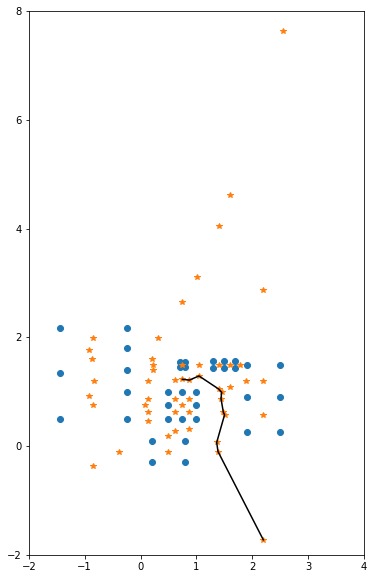

In [318]:
for edge in edges:
    graph.add_edge(*edge)
    
shortest = dijsktra(graph, '1', '18')

plt.figure(figsize=(6,10))    
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
plt.xlim(-2, 4); plt.ylim(-2, 8)

x = []
y = []

for pt in shortest:
    idx = int(pt)
    x.append(vor.vertices[idx, 0])  
    y.append(vor.vertices[idx, 1])
    # print (pt,x,y)
    
plt.plot(x,y,'k-', color="black")

In [319]:
shortest

['1', '21', '22', '11', '10', '31', '32', '33', '35', '36', '18']

## Implement Pursuit

In [388]:
robot_params = {
    # pose
    "start_x": 1.0,
    "start_y": 0.3,
    "start_theta": 0,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    "focal_length": 0.00315, # camera focal lenght in meter
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.5, # Equivalent to motor speed setting of 0.3
}

control_params = {
    "num_iter": 100,
    "interval": 10,
    "debug": True,
    "motion": True,
    "path": None  # This is where the path is stored
}

pursuit_params = {
    "K_v": 0.5,
    "K_i": 0.0001,
    "K_h": 0.5,
    "lag": 0.02
}

trajec_params = {
    "points": [],
    "current": 0,
}

In [390]:
def distance(pt1, pt2):
    """ Distance between 2 points """
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.linalg.norm(pt1-pt2)
    
def generate_points(start, end, interval, debug=False):
    """ Generate a sequence of equally distance points for a path """
    start_x, start_y = start
    end_x, end_y = end
    theta = math.atan2((end_y-start_y),(end_x-start_x))
       
    if debug:
        print("From {} to {}".format(np.around(np.array(start),3), np.around(np.array(end),3)))
        print("theta: {:.1f}".format(theta))
    
    points = []
    current_pt = start
    next_pt = start
    
    # Generate a sequence of points from start to end
    while distance(start,next_pt) < distance(start,end):
        points.append(current_pt)
        next_pt = (current_pt[0] + interval*math.cos(theta), current_pt[1]+interval*math.sin(theta))
        points.append(next_pt)
        current_pt = next_pt
        
    return points

def generate_trajectory(path, vor, interval, debug=False):
    """ Convert path into points for robot to follow """
    
    points = []
    # for each path segment
    for i in range(len(path)-1):
        # generate points for the segment
        start = [vor.vertices[int(path[i]), 0],vor.vertices[int(path[i]), 1]]
        end = [vor.vertices[int(path[i+1]), 0],vor.vertices[int(path[i+1]), 1]]
        if debug:
            print(path[i], path[i+1])
        points.extend(generate_points(start,end,interval)) 
        
    return points

def closest_point(traj, robot_pose):
    """ Pick the next point in the trajectory to pursue """
    robot_x = robot_pose[0]
    robot_y = robot_pose[1]
    robot_theta = robot_pose[2]
    
    current = traj["current"]
    points = traj["points"][current:]
    
    nearest = None
    # Go through all pts in trajectory and pick the pt nearest to robot
    for i, pt in enumerate(points):
        if nearest is None:
            nearest = pt
        else:
            if distance(pt,[robot_x,robot_y])<distance(nearest,[robot_x,robot_y]):
                nearest = pt
                current = traj["current"]+i
                
    return current, nearest


1 21
21 22
22 11
11 10
10 31
31 32
32 33
33 35
35 36
36 18


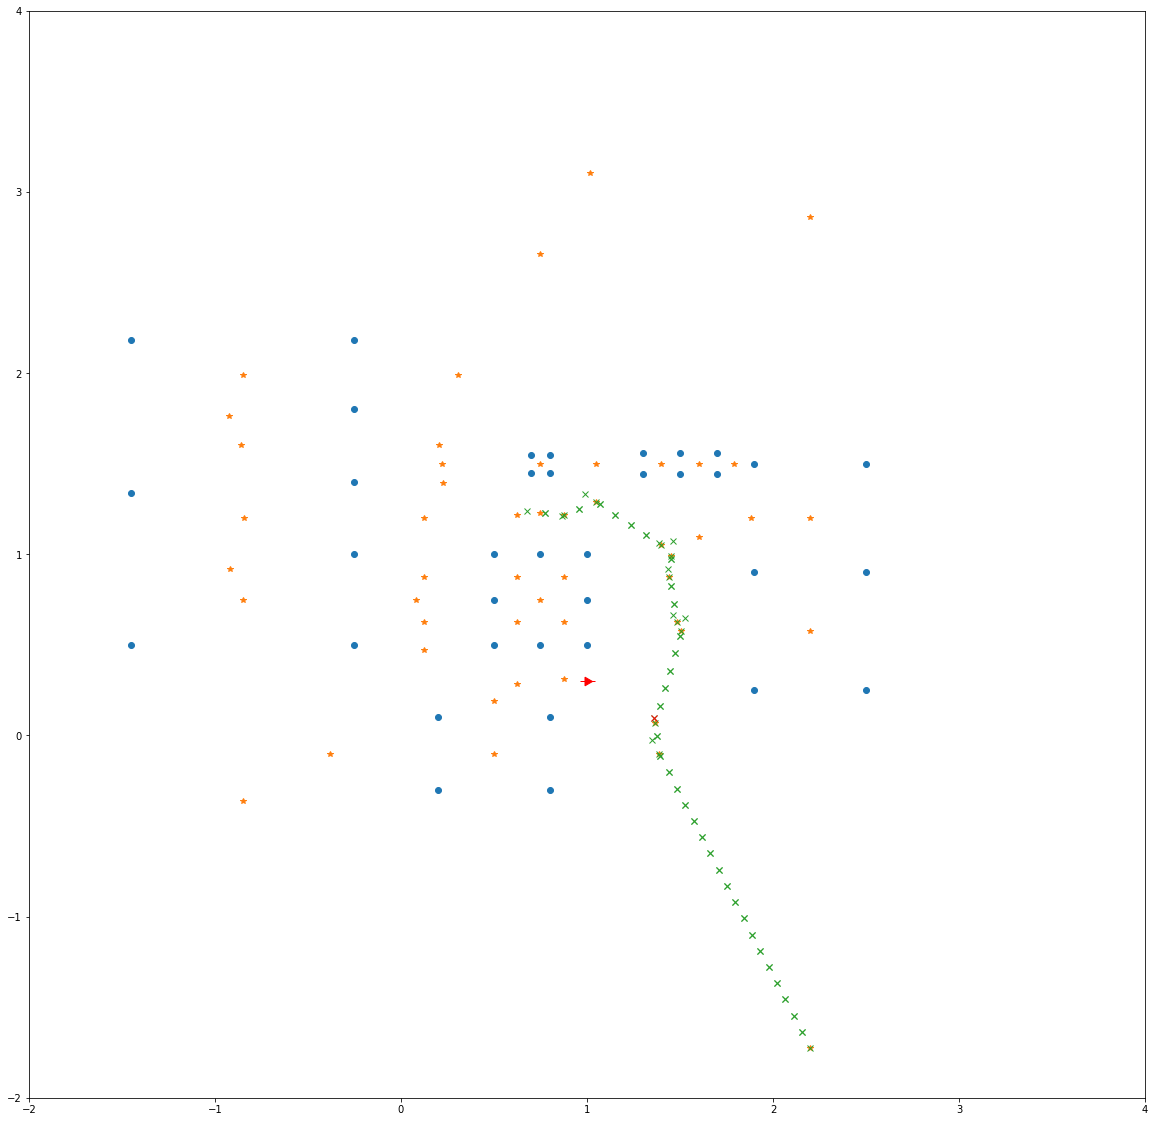

In [391]:
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]

trajec_params["points"] = generate_trajectory(shortest, vor, 0.10, debug=True)
trajec_params["current"] = 0
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)

def animate_robot(robot_pose, landmarks, vor, path=None, pursuit_pt=None):
    plt.figure(figsize=(20,20))    
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    plt.xlim(-2, 4); plt.ylim(-2, 4)
    
    if path is not None:
        path = np.array(path)
        plt.plot(path[:,0],path[:,1], 'x')

    robot_x_actual = robot_pose[0]
    robot_y_actual = robot_pose[1]
    robot_theta_actual = robot_pose[2]*180/math.pi - 90 # Adjust orientation to match matplotlib    
    
    # robot = line + triangle
    plt.plot(robot_x_actual, robot_y_actual, marker=(2, 0, robot_theta_actual), \
             c='r',markersize=15, linestyle='None')
    plt.plot(robot_x_actual, robot_y_actual, marker=(3, 0, robot_theta_actual), \
             c='r',markersize=10, linestyle='None')

    # next pursuit pt
    if pursuit_pt is not None:
        plt.plot(pursuit_pt[0],pursuit_pt[1], 'x', c='r')

    plt.show()
    plt.close()
    
    return

animate_robot(robot_pose, points, vor, path=trajectory, pursuit_pt=pursuit_pt)

1 21
21 22
22 11
11 10
10 31
31 32
32 33
33 35
35 36
36 18


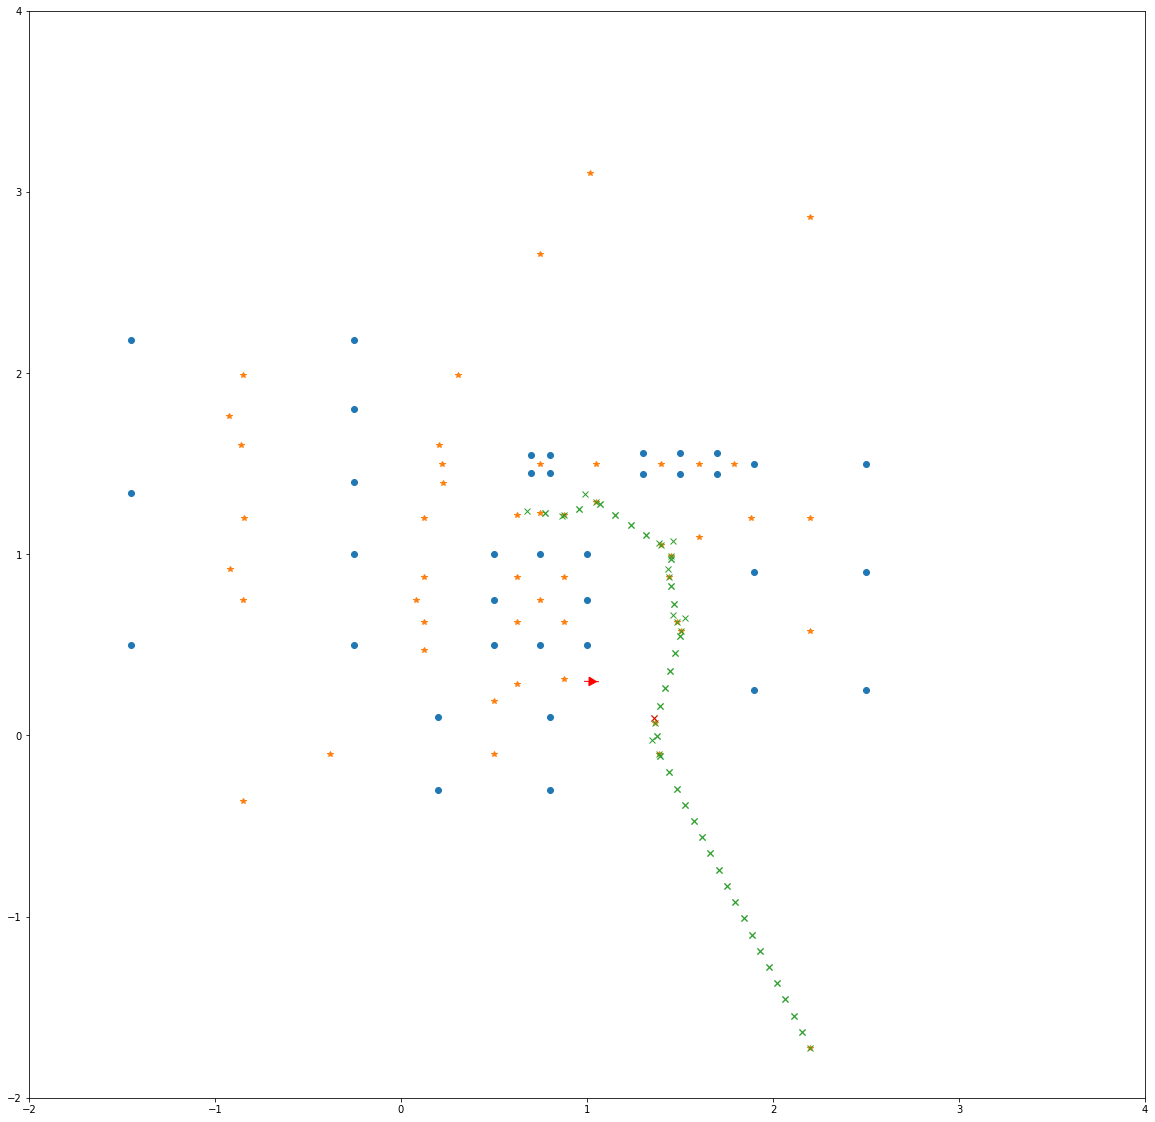

Step:  1
(v,omega): (0.1965677106781505, -0.25520893987061566)
(x,y,theta): 1.0196546373422872, 0.29974918442851867, -0.025520893987061567


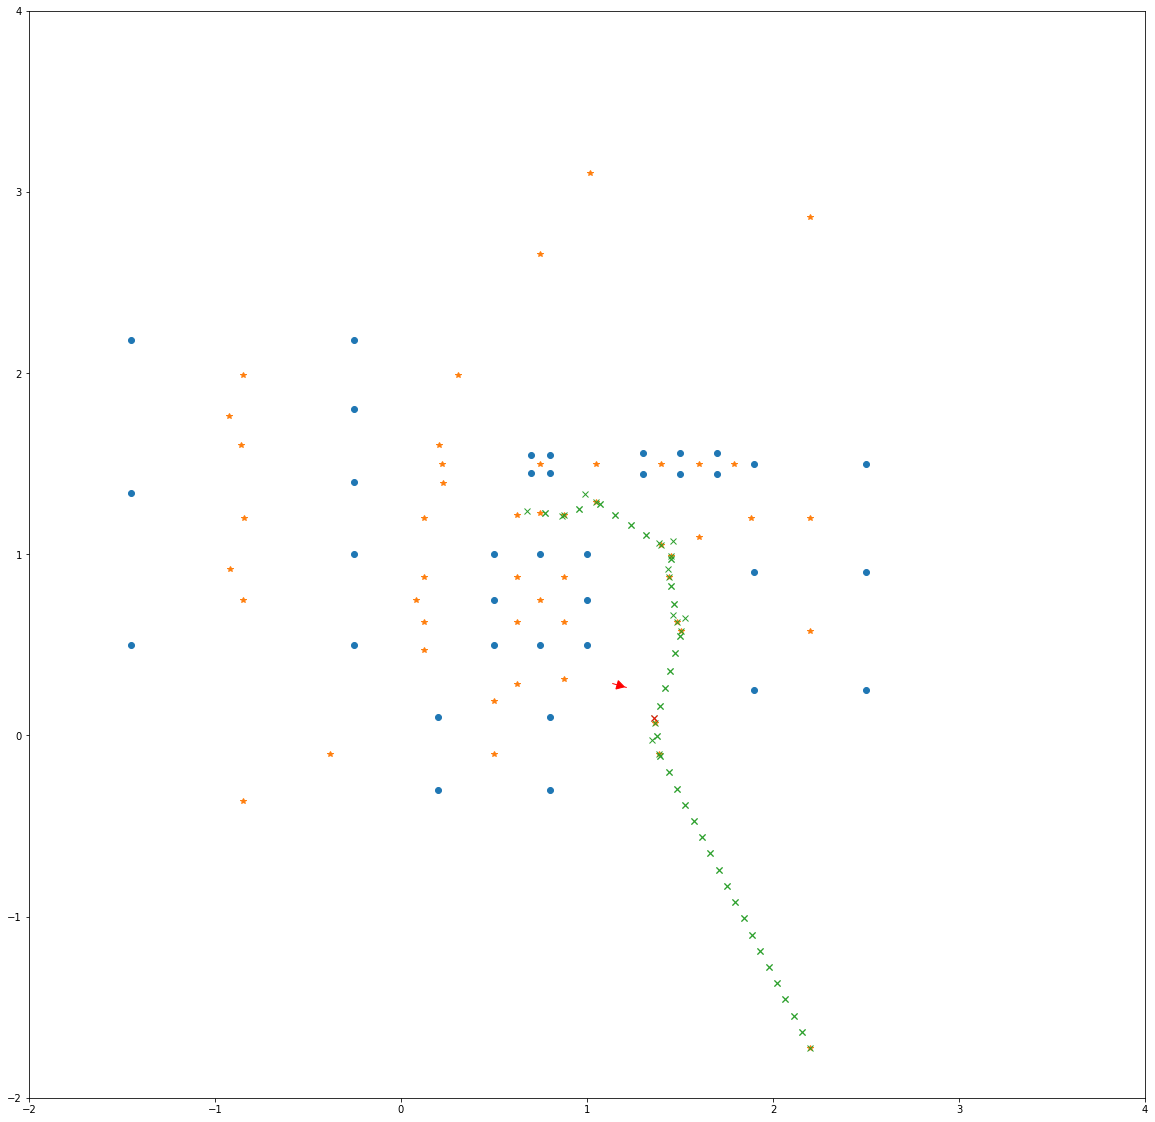

Step:  11
(v,omega): (0.1257843862224913, -0.24522247207494716)
(x,y,theta): 1.17279920789017, 0.27783864852475193, -0.27540714239762626


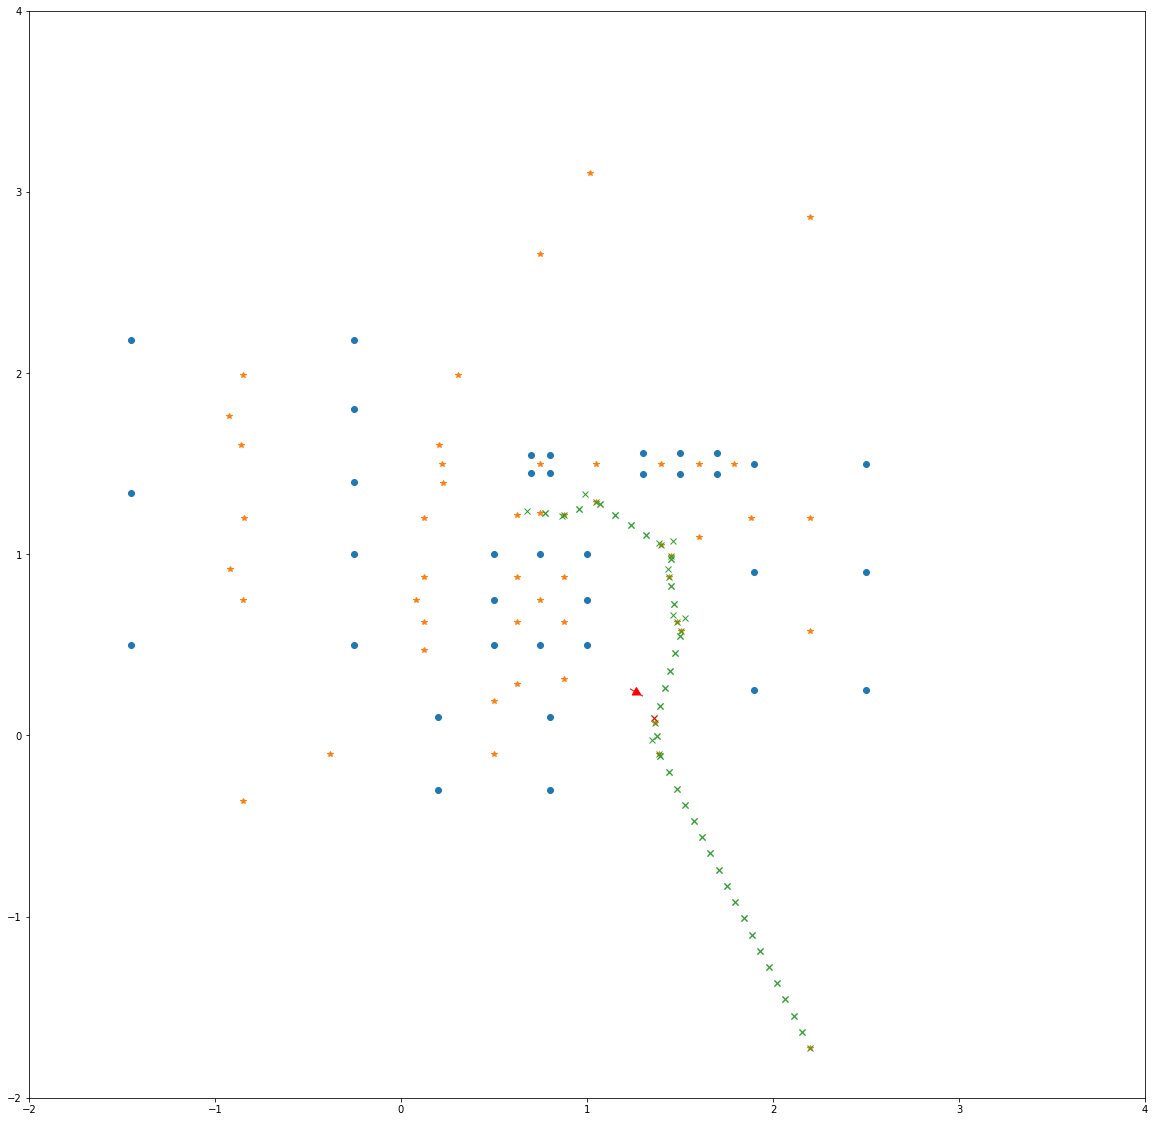

Step:  21
(v,omega): (0.08004898468818022, -0.23271687290495174)
(x,y,theta): 1.2642493119429157, 0.24058241733716867, -0.5139991773968057


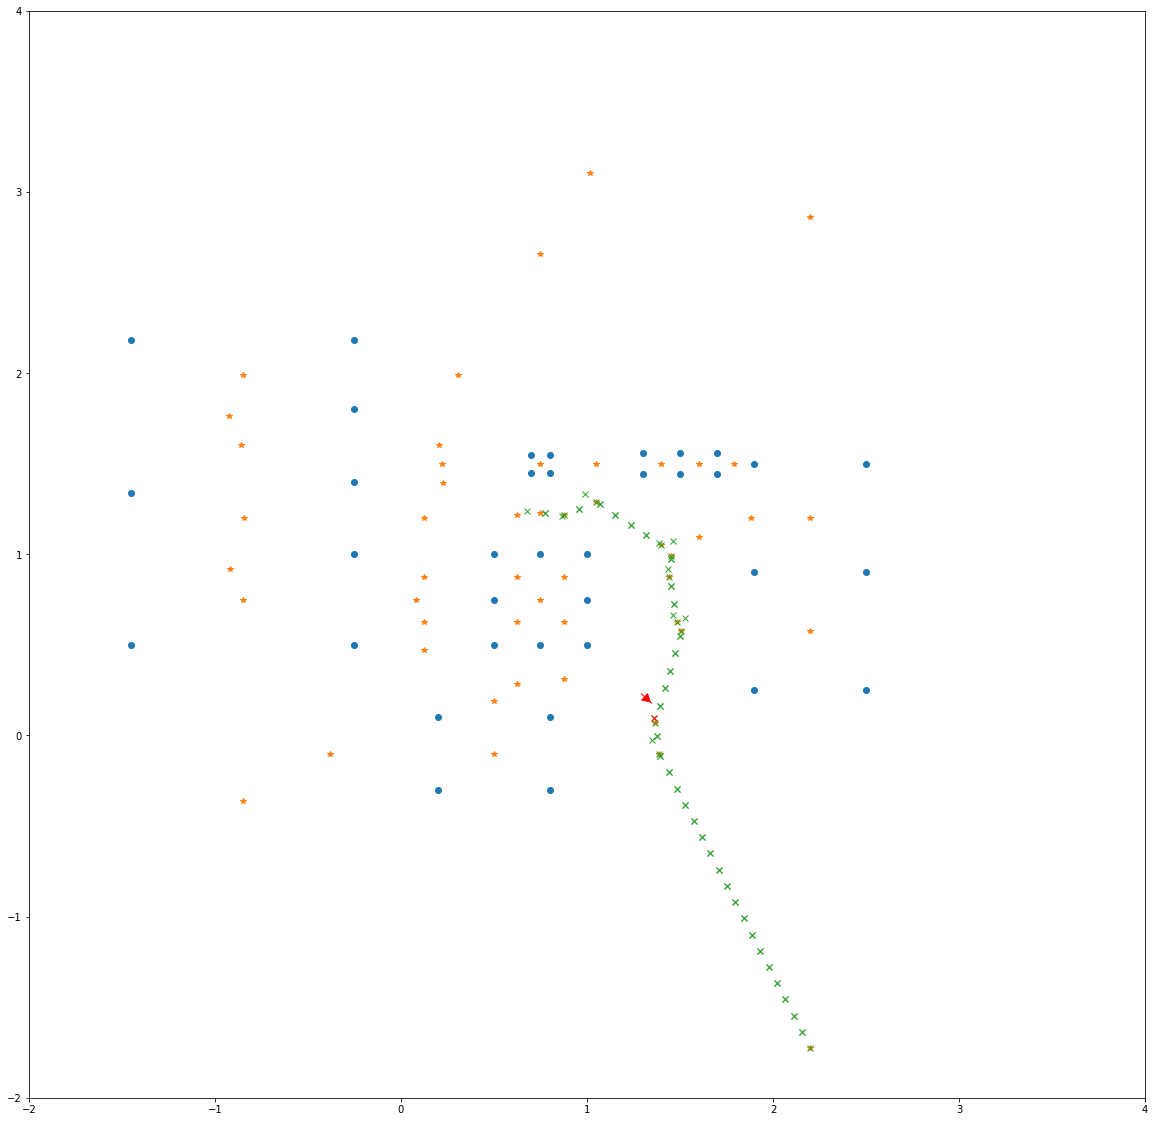

Step:  31
(v,omega): (0.05060572855937661, -0.21669405958962756)
(x,y,theta): 1.3152784002899618, 0.20423049281756378, -0.7382358907250526


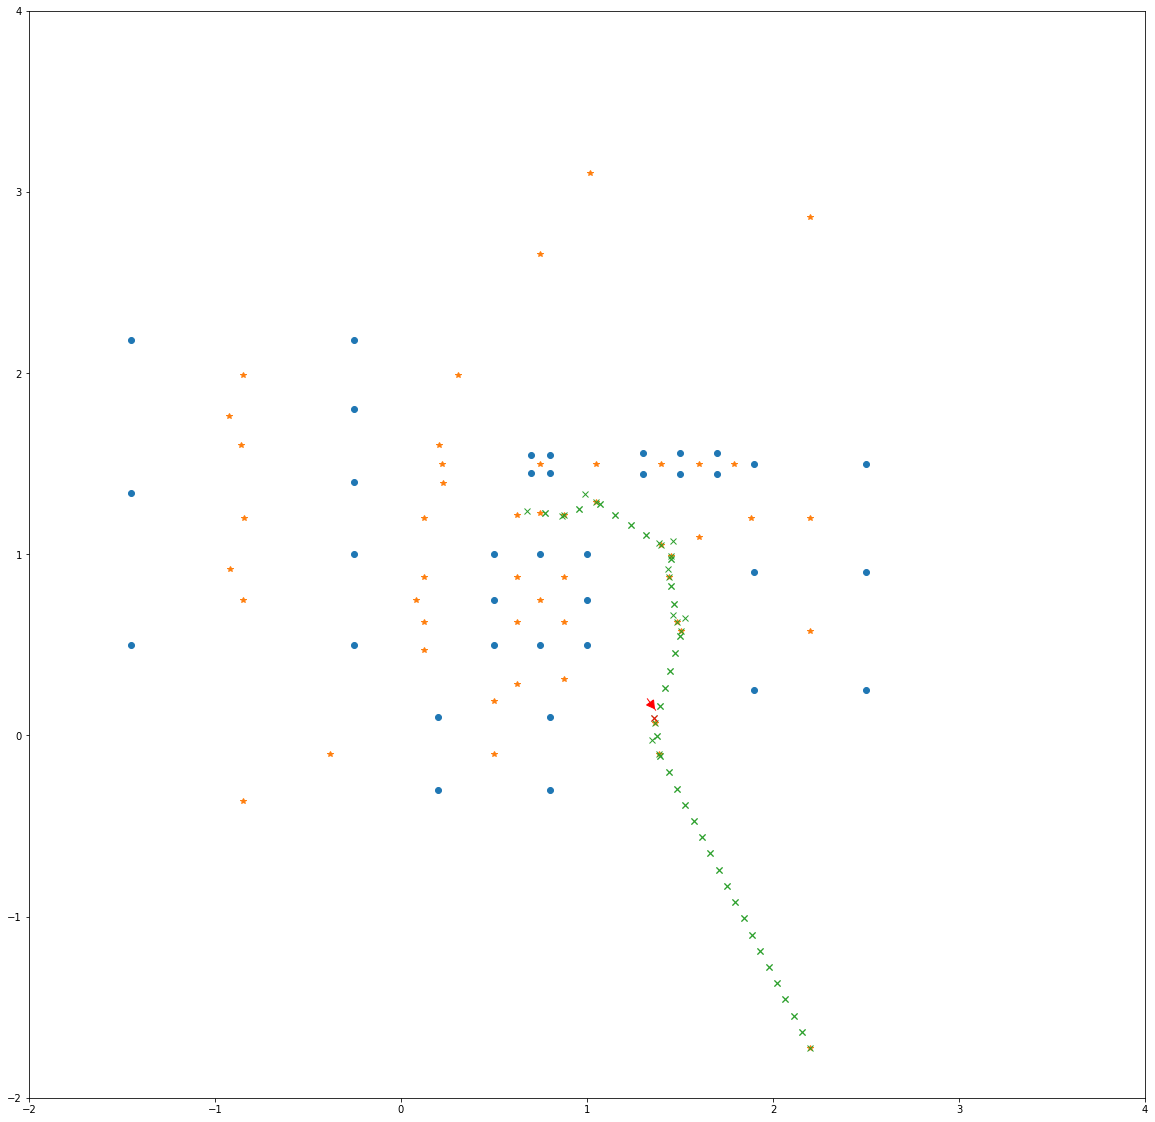

Step:  41
(v,omega): (0.03173814177708014, -0.196217446764213)
(x,y,theta): 1.3417675639646467, 0.17497705016735807, -0.9440648165236311


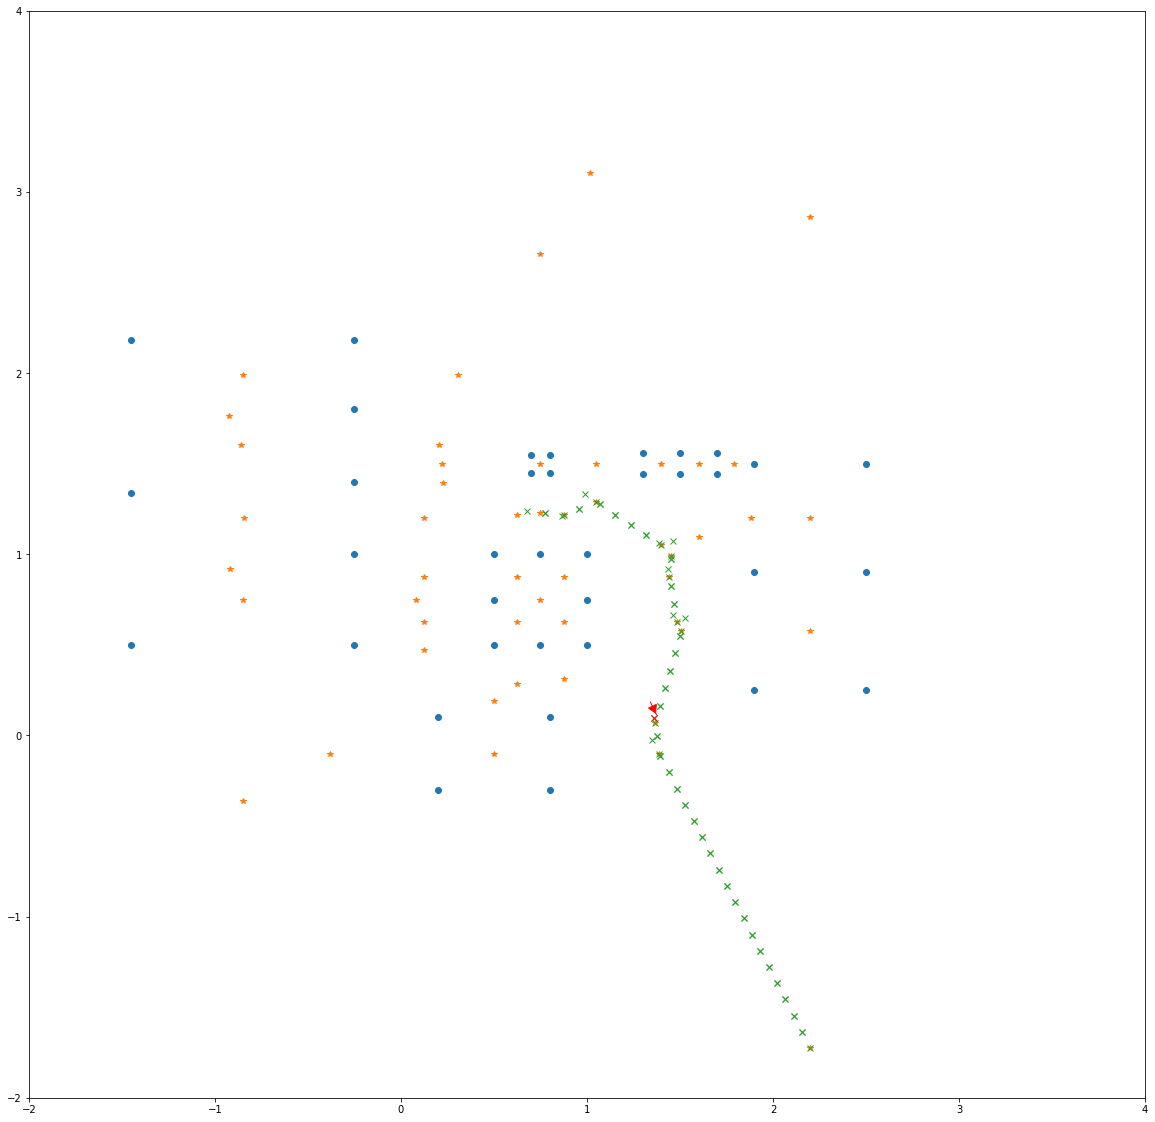

Step:  51
(v,omega): (0.0197237033730099, -0.1708816598795464)
(x,y,theta): 1.3544484744181668, 0.15384334743868003, -1.1267389855946628


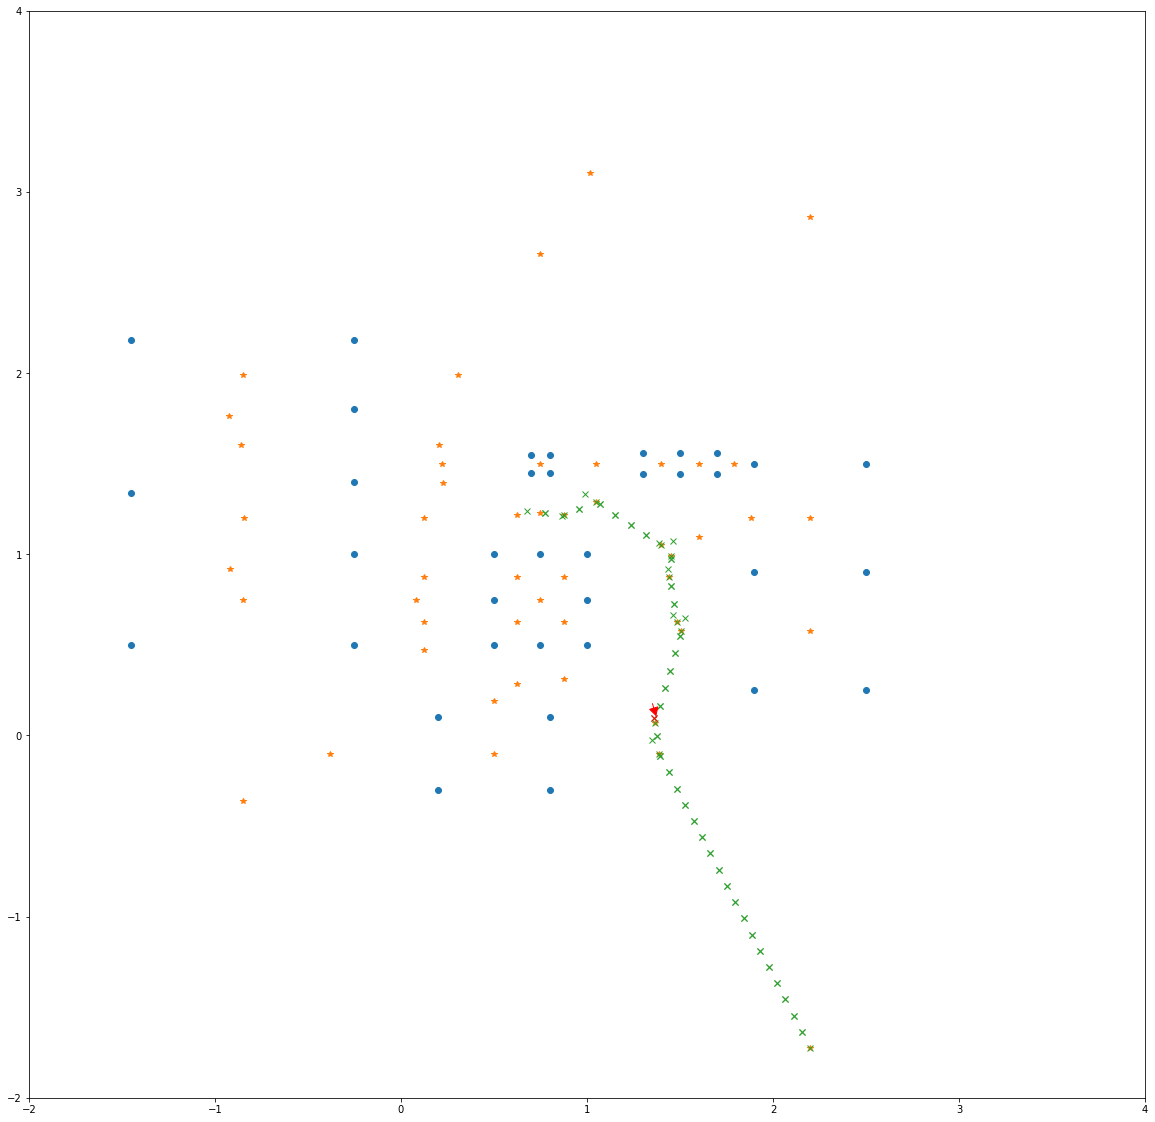

Step:  61
(v,omega): (0.012139555993793245, -0.14147316128357124)
(x,y,theta): 1.3599666945631594, 0.13962992975740127, -1.281707868756545


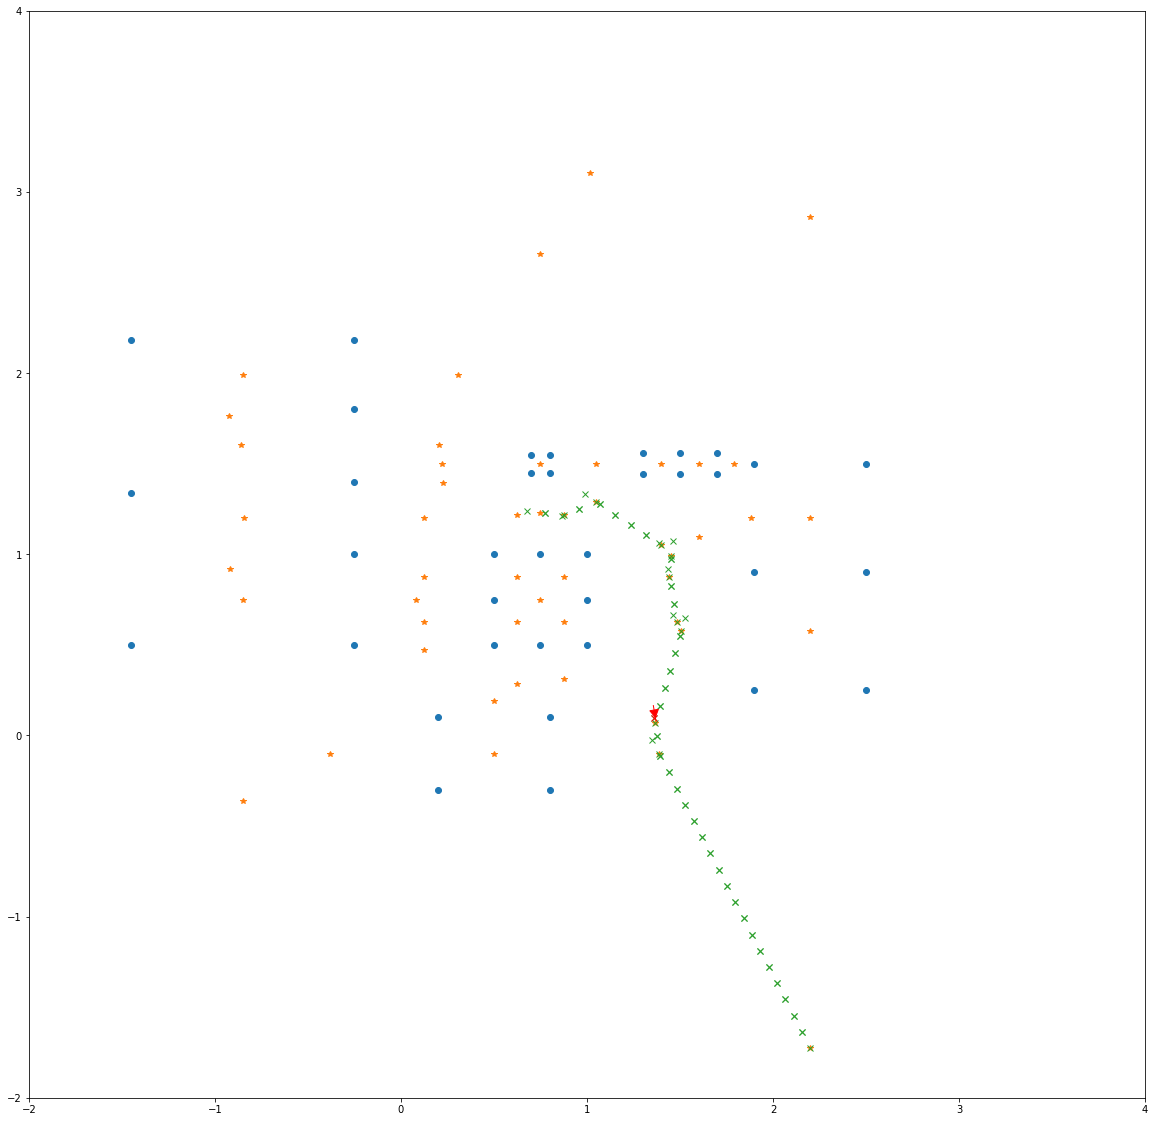

Step:  71
(v,omega): (0.007404789806102268, -0.11035325331778911)
(x,y,theta): 1.3620913560434764, 0.13053107087397586, -1.4060730797021566


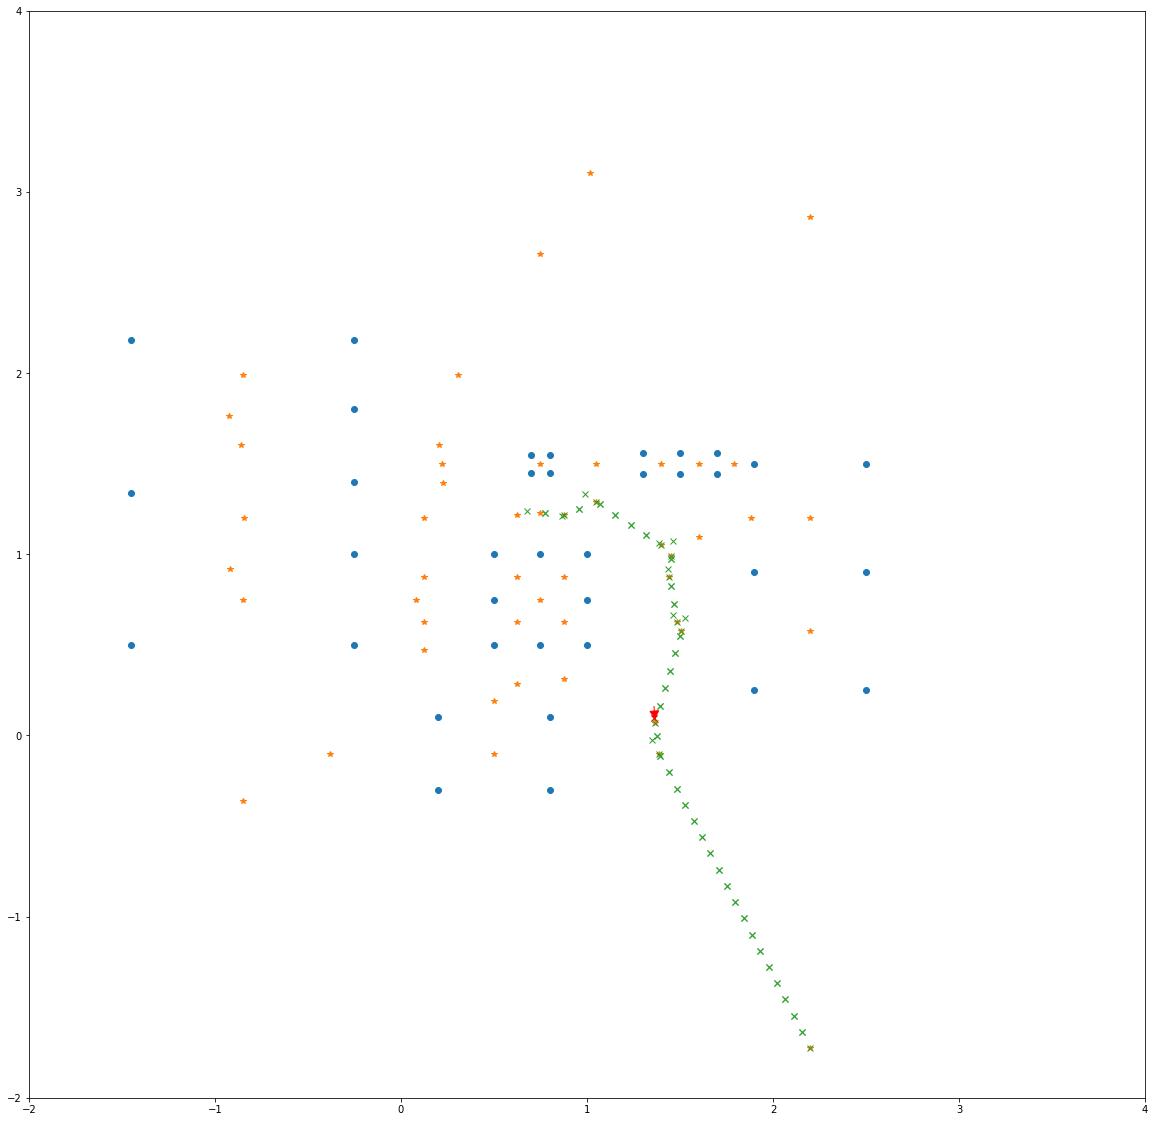

Step:  81
(v,omega): (0.004484395470322839, -0.08088693099521982)
(x,y,theta): 1.3627669428552256, 0.12489233087963991, -1.4999443760233069


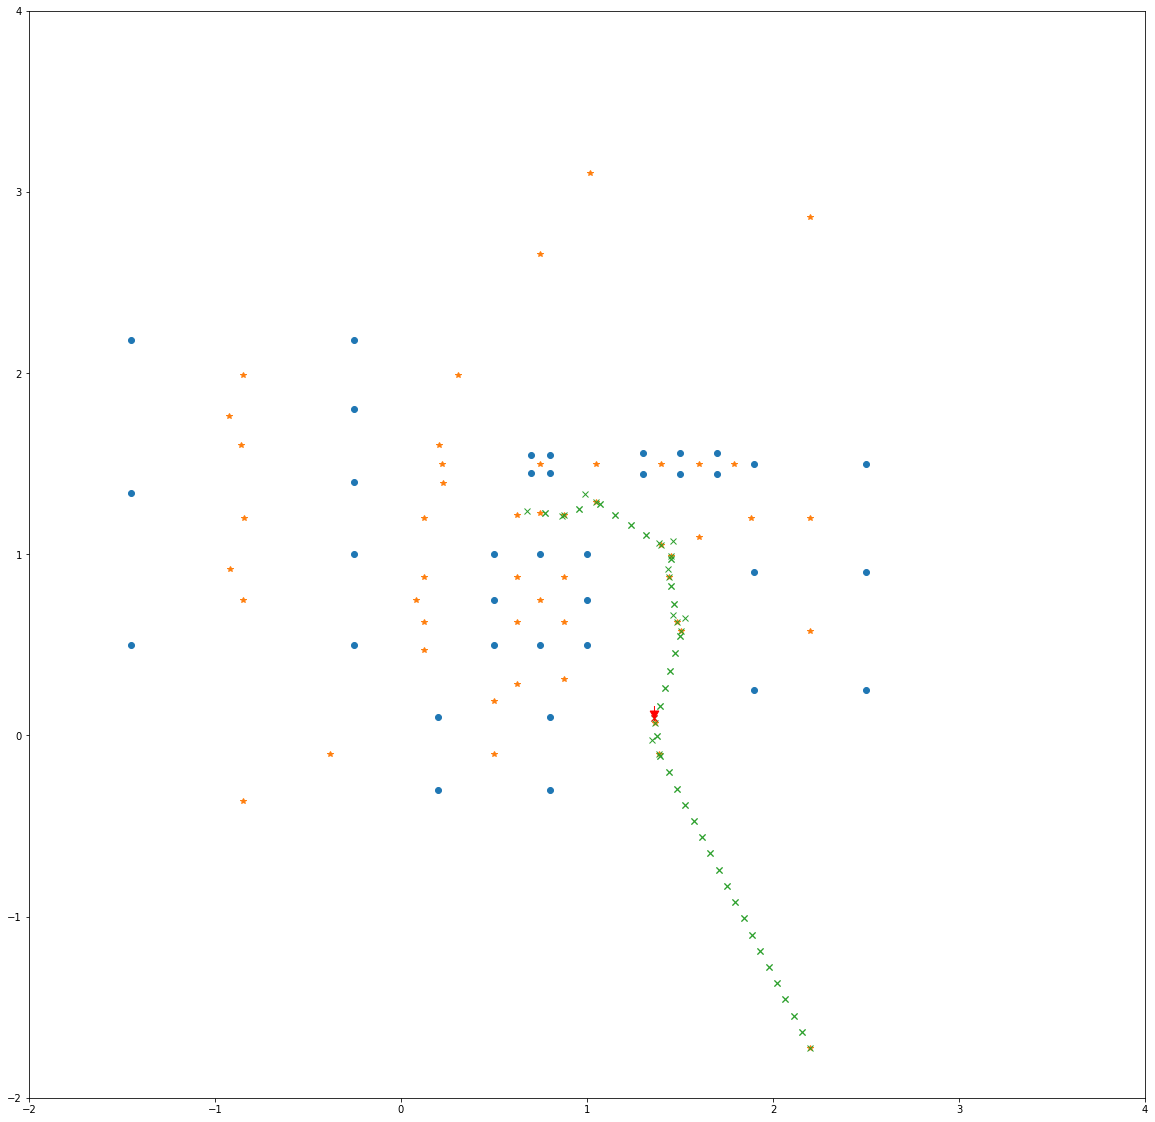

Step:  91
(v,omega): (0.0027024980069659393, -0.055994185205049396)
(x,y,theta): 1.362898077127167, 0.12146414173698397, -1.56668053440614


In [393]:
# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"] 

# load robot parameters 
dt = robot_params["motor_on_time"]
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]

trajec_params["points"] = generate_trajectory(shortest, vor, 0.10, debug=True)
trajec_params["current"] = 0

# set trajectory's closest pt as next pursuit pt
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)

K_v = pursuit_params['K_v']
K_i = pursuit_params['K_i']
K_h = pursuit_params['K_h']
lag = pursuit_params['lag']

robot_x = robot_pose[0]
robot_y = robot_pose[1]
robot_theta = robot_pose[2]
sum_errors = 0

""" Robot pursuit a moving point """
for i in range(num_iter):
    
    pursuit_x = pursuit_pt[0]
    pursuit_y = pursuit_pt[1]
    
    robot_pos = [robot_x ,robot_y]
    error_pos = distance(robot_pos,pursuit)-lag
    
    v = K_v*error_pos + K_i*sum_errors
    sum_errors += error_pos
    
    theta = normalize_angle(math.atan2((pursuit_y-robot_y),(pursuit_x-robot_x)))
    omega = K_h*(theta-robot_theta)
    
    """ Move robot - Take 1 step in a left circular trajectory of radius 0.4m """
    robot_velocities = (v,omega)
    d_x,d_y,d_theta = robot_pose_delta(v,omega,robot_theta,dt)
    
    robot_x += d_x
    robot_y += d_y
    robot_theta += d_theta
    robot_pose = [robot_x,robot_y,robot_theta]
    
    if i%interval==0:
        animate_robot(robot_pose, points, vor, path=trajectory, pursuit_pt=pursuit_pt)
        print("Step: ", i+1)
        # print("(w_r,w_l): {}".format(wheel_velocities))
        print("(v,omega): {}".format(robot_velocities))
        print("(x,y,theta): {}, {}, {}".format(robot_x,robot_y,robot_theta))



In [392]:
trajec_params

{'current': 41,
 'points': [[2.2, -1.7249999999999999],
  (2.155278640450004, -1.6355572809000083),
  (2.155278640450004, -1.6355572809000083),
  (2.110557280900008, -1.5461145618000167),
  (2.110557280900008, -1.5461145618000167),
  (2.065835921350012, -1.4566718427000251),
  (2.065835921350012, -1.4566718427000251),
  (2.021114561800016, -1.3672291236000336),
  (2.021114561800016, -1.3672291236000336),
  (1.9763932022500204, -1.277786404500042),
  (1.9763932022500204, -1.277786404500042),
  (1.9316718427000246, -1.1883436854000504),
  (1.9316718427000246, -1.1883436854000504),
  (1.8869504831500288, -1.0989009663000588),
  (1.8869504831500288, -1.0989009663000588),
  (1.842229123600033, -1.0094582472000673),
  (1.842229123600033, -1.0094582472000673),
  (1.7975077640500372, -0.9200155281000757),
  (1.7975077640500372, -0.9200155281000757),
  (1.7527864045000414, -0.8305728090000841),
  (1.7527864045000414, -0.8305728090000841),
  (1.7080650449500456, -0.7411300899000925),
  (1.708065